In [1]:
%pwd

'/content'

In [2]:
! git clone https://github.com/clovaai/CRAFT-pytorch.git

Cloning into 'CRAFT-pytorch'...
remote: Enumerating objects: 56, done.
remote: Total 56 (delta 0), reused 0 (delta 0), pack-reused 56
Unpacking objects: 100% (56/56), done.


In [3]:
!git clone https://github.com/sujaykhandekar/Automated-objects-removal-inpainter.git

Cloning into 'Automated-objects-removal-inpainter'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (220/220), done.
remote: Compressing objects: 100% (200/200), done.
remote: Total 220 (delta 82), reused 81 (delta 2), pack-reused 0
Receiving objects: 100% (220/220), 1.71 MiB | 10.15 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [4]:
!pip install ipyplot

In [5]:
import sys

In [6]:
sys.path.append('/content/CRAFT-pytorch')
sys.path.append('/content/Automated-objects-removal-inpainter')


In [7]:
# create dir for models
% mkdir weights
# craft main
! wget -O weights/craft_mlt_25k.pth https://drive.google.com/uc?id=1Jk4eGD7crsqCCg9C9VjCLkMN3ze8kutZ&export=download
# craft refiner
# !!!!!!!!!!Есть вероятность что она не нужна!!!!!!!!!!!!!!!
!wget -O weights/craft_refiner_CTW1500.pth https://drive.google.com/uc?id=1XSaFwBkOaFOdtk4Ane3DFyJGPRw6v5bO&export=download
# Automated-objects-removal-inpainter
!bash ./Automated-objects-removal-inpainter/scripts/download_model.sh
#Copy edge model
%cp ./checkpoints/celeba/* ./checkpoints/
#%cp ./checkpoints/psv/* ./checkpoints/
#%cp ./checkpoints/places2/* ./checkpoints/


--2021-06-11 17:00:38--  https://drive.google.com/uc?id=1Jk4eGD7crsqCCg9C9VjCLkMN3ze8kutZ
Resolving drive.google.com (drive.google.com)... 74.125.199.139, 74.125.199.138, 74.125.199.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.199.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-9g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vbpbd588qv4f7onbmtmgeeacghjt7c8p/1623430800000/05173585031594261940/*/1Jk4eGD7crsqCCg9C9VjCLkMN3ze8kutZ [following]
--2021-06-11 17:00:41--  https://doc-0k-9g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vbpbd588qv4f7onbmtmgeeacghjt7c8p/1623430800000/05173585031594261940/*/1Jk4eGD7crsqCCg9C9VjCLkMN3ze8kutZ
Resolving doc-0k-9g-docs.googleusercontent.com (doc-0k-9g-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-0k-9g-docs.googleusercontent.com (doc-0k-9g-docs.googleusercontent.com)|74.125

In [8]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
from shapely.geometry import Point, Polygon

import ipyplot

#### Craft imports
# import sys
import os
import time
import argparse

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

from PIL import Image

import cv2
from skimage import io
import numpy as np
import craft_utils
import imgproc
import file_utils
import json
import zipfile

from craft import CRAFT

from collections import OrderedDict


####### Craft Dataset

import re
import six
import math
import lmdb
import torch

from natsort import natsorted
from torch.utils.data import Dataset, ConcatDataset, Subset
from torch._utils import _accumulate
import torchvision.transforms as transforms


############ Object remover
import glob
import random
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader
from imageio import imread
from skimage.feature import canny
from skimage.color import rgb2gray, gray2rgb
from src.utils import create_mask
from src.segmentor_fcn import segmentor,fill_gaps





######## Edge Connect (Дорисовываем картинку из штрихов)
from src.dataset import Dataset
from src.models import EdgeModel, InpaintingModel
from src.utils import Progbar, create_dir, stitch_images, imsave
from torchvision import transforms


######## Object remover MAIN
from shutil import copyfile
from src.config import Config


        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `base_64` param to `True`.
        


Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


In [9]:
#### Craft imports


def copyStateDict(state_dict):
    if list(state_dict.keys())[0].startswith("module"):
        start_idx = 1
    else:
        start_idx = 0
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = ".".join(k.split(".")[start_idx:])
        new_state_dict[name] = v
    return new_state_dict

def str2bool(v):
    return v.lower() in ("yes", "y", "true", "t", "1")


def create_craft_args(refine):
        
    args = argparse.Namespace()
    args.trained_model = 'weights/craft_mlt_25k.pth'
    # args.text_threshold = 0.6 # 0.7
    # args.low_text = 0.35 # 0.4
    # args.link_threshold = 0.6 # 0.4
    args.text_threshold = 0.7 # 0.6
    args.low_text = 0.4 # 0.35
    args.link_threshold = 0.4 # 0.6
    if torch.cuda.is_available():
        args.cuda = True
    else:
        args.cuda = False
    args.canvas_size = 1280
    args.mag_ratio = 1.5
    args.poly = False
    args.show_time = False
    args.test_folder = './data'
    args.refine = refine
    args.refiner_model = 'weights/craft_refiner_CTW1500.pth'
    return args

""" For test images in a folder """
# image_list, _, _ = file_utils.get_files(args.test_folder)

# result_folder = './result/'
# if not os.path.isdir(result_folder):
#     os.mkdir(result_folder)

def test_net(args, net, image, text_threshold, link_threshold, low_text, cuda, poly, refine_net=None):
    t0 = time.time()

    # resize
    img_resized, target_ratio, size_heatmap = imgproc.resize_aspect_ratio(image, args.canvas_size, interpolation=cv2.INTER_LINEAR, mag_ratio=args.mag_ratio)
    ratio_h = ratio_w = 1 / target_ratio

    # preprocessing
    x = imgproc.normalizeMeanVariance(img_resized)
    x = torch.from_numpy(x).permute(2, 0, 1)    # [h, w, c] to [c, h, w]
    x = Variable(x.unsqueeze(0))                # [c, h, w] to [b, c, h, w]
    if cuda:
        x = x.cuda()

    # forward pass
    with torch.no_grad():
        y, feature = net(x)

    # make score and link map
    score_text = y[0,:,:,0].cpu().data.numpy()
    score_link = y[0,:,:,1].cpu().data.numpy()

    # refine link
    if refine_net is not None:
        with torch.no_grad():
            y_refiner = refine_net(y, feature)
        score_link = y_refiner[0,:,:,0].cpu().data.numpy()

    t0 = time.time() - t0
    t1 = time.time()

    # Post-processing
    boxes, polys = craft_utils.getDetBoxes(score_text, score_link, text_threshold, link_threshold, low_text, poly)

    # coordinate adjustment
    boxes = craft_utils.adjustResultCoordinates(boxes, ratio_w, ratio_h)
    polys = craft_utils.adjustResultCoordinates(polys, ratio_w, ratio_h)
    for k in range(len(polys)):
        if polys[k] is None: polys[k] = boxes[k]

    t1 = time.time() - t1

    # render results (optional)
    render_img = score_text.copy()
    render_img = np.hstack((render_img, score_link))
    ret_score_text = imgproc.cvt2HeatmapImg(render_img)

    if args.show_time : print("\ninfer/postproc time : {:.3f}/{:.3f}".format(t0, t1))

    return boxes, polys, ret_score_text


def create_text_mask(args, image_array, debug=False):
    # load net
    net = CRAFT()     # initialize

    if debug:
        print('Loading weights from checkpoint (' + args.trained_model + ')')

    if args.cuda:
        net.load_state_dict(copyStateDict(torch.load(args.trained_model)))
    else:
        net.load_state_dict(copyStateDict(torch.load(args.trained_model, map_location='cpu')))

    if args.cuda:
        net = net.cuda()
        net = torch.nn.DataParallel(net)
        cudnn.benchmark = False

    net.eval()

    # LinkRefiner
    refine_net = None
    if args.refine:
        from refinenet import RefineNet
        refine_net = RefineNet()
        
        if debug:
            print('Loading weights of refiner from checkpoint (' + args.refiner_model + ')')

        if args.cuda:
            refine_net.load_state_dict(copyStateDict(torch.load(args.refiner_model)))
            refine_net = refine_net.cuda()
            refine_net = torch.nn.DataParallel(refine_net)
        else:
            refine_net.load_state_dict(copyStateDict(torch.load(args.refiner_model, map_location='cpu')))

        refine_net.eval()
        args.poly = True

    t = time.time()

    image = image_array

    bboxes, polys, score_text = test_net(args, net, image, args.text_threshold, args.link_threshold, args.low_text, args.cuda, args.poly, refine_net)

    final_bboxes = np.around(bboxes).astype(int)

    final_polys = [np.around(x).astype(int).reshape(-1).tolist() for x in polys]
    # final_polys = [np.around(x).astype(int) for x in polys]

    # return final_bboxes, final_polys
    return bboxes, polys, score_text

In [10]:
def display_image_boxes(image_array, boxes):
    import PIL.ImageDraw as ImageDraw
    import PIL.Image as Image
    mask = Image.new("L", (image_array.shape[1], image_array.shape[0]))
    draw = ImageDraw.Draw(mask)
    for i in range(len(boxes)):
        draw.polygon(boxes[i], outline=256, fill=256)
    display(mask)


def transform_bboxes_to_rectangles(bboxes):
    rectangles = [[[x.min(axis=0)[0], x.min(axis=0)[1]],
                    [x.max(axis=0)[0], x.min(axis=0)[1]],
                    [x.max(axis=0)[0], x.max(axis=0)[1]],
                    [x.min(axis=0)[0], x.max(axis=0)[1]]] for x in bboxes]
    return np.array(rectangles)

def create_cutted_images_list(image_array, rectangles):
    list_ = []
    for i in range(len(rectangles)):
        # display(Image.fromarray(np.array(mask)))
        x = rectangles[i].astype(int)
        list_.append(image_array[
        x[1][1]:x[3][1], 
        x[0][0]:x[2][0], 
        :
        ])
        
    return list_

def get_image_mask_from_boxes(image_array, boxes):
    import PIL.ImageDraw as ImageDraw
    import PIL.Image as Image
    mask = Image.new("L", (image_array.shape[1], image_array.shape[0]))
    draw = ImageDraw.Draw(mask)
    for i in range(len(boxes)):
        draw.polygon(boxes[i], outline=256, fill=256)
    return np.array(mask)

In [11]:
####### Craft Dataset

############################################
########## ХЗ может это и не нужно##########
############################################
class CustomsDataset(Dataset):
    def __init__(self, array_of_cutted_images, opt):
        self.opt = opt
        self.array_of_cutted_images = array_of_cutted_images
    def __len__(self):
        return len(self.array_of_cutted_images)
    def __getitem__(self, index):
        # (images, index_images) index_images = string/int - identifyer
        #return (self.array_of_cutted_images[index], index)
        if self.opt.rgb:
            img = Image.fromarray(self.array_of_cutted_images[index]).convert('RGB')  # for color image
        else:
            img = Image.fromarray(self.array_of_cutted_images[index]).convert('L')
        # print(f'Getted image for index {index}')
        return (img, str(index))

In [12]:
##########################################################################
###############Удаление текста с картинки#################################
##########################################################################

############ Object remover
# import os
# import glob
# import torch
# import random
# import numpy as np
# import torchvision.transforms.functional as F
# from torch.utils.data import DataLoader
# from PIL import Image
# from imageio import imread
# from skimage.feature import canny
# from skimage.color import rgb2gray, gray2rgb
# #from .utils import create_mask
# from src.utils import create_mask
# import cv2
# #from .segmentor_fcn import segmentor,fill_gaps
# from src.segmentor_fcn import segmentor,fill_gaps


class DatasetForRemoveWithMask(torch.utils.data.Dataset):
    def __init__(self, config, flist, edge_flist, image_data_list, augment=True, training=True, debug=True):
        super(DatasetForRemoveWithMask, self).__init__()
        self.augment = augment
        self.training = training
        self.data = self.load_flist(flist)
        self.edge_data = self.load_flist(edge_flist)

        self.debug = debug

        self.input_size = config.INPUT_SIZE
        self.sigma = config.SIGMA
        self.edge = config.EDGE
        self.mask = config.MASK
        self.nms = config.NMS
        self.device = config.SEG_DEVICE
        self.objects = config.OBJECTS
        self.segment_net = config.SEG_NETWORK
        # in test mode, there's a one-to-one relationship between mask and image
        # masks are loaded non random
        
        # Наш массив с инфой
        self.image_data_list = image_data_list

    def __len__(self):
        #######################################################################
        #######################################################################
        #######################################################################
        #######################################################################
        # НЕ ЗАБЫТЬ ПОМЕНЯТЬ НА ПРАВИЛЬНОЕ ЗНАЧЕНИЕ
        # Если у будем обрабатывать более 1ой картинки, то
        # len(self.image_data_list[0]["word_bboxes"]) > 0
        #######################################################################
        #######################################################################
        #######################################################################
        #######################################################################
        return len(self.image_data_list[0]["word_bboxes"])
        #return len(self.data)

    def __getitem__(self, index):
        try:
            item = self.load_item(index)
        except:
            print("Load image - ", self.image_data_list[index]["image_path"])
            item = self.load_item(index)

        return item

    def load_name(self, index):
        return self.image_data_list[index]["image_file_name"]
        
    def load_size(self, index):
        # ХАРДКОД, модель не умеет работать с большими размерами
        # Только с картинками 256 на 256
        return 256, 256 

#######################################################################
    def centroid(self, vertexes):
        _x_list = [vertex [0] for vertex in vertexes]
        _y_list = [vertex [1] for vertex in vertexes]
        _len = len(vertexes)
        _x = sum(_x_list) / _len
        _y = sum(_y_list) / _len
        return(_x, _y)

    def create_cutted_images_list_from_rectangle(self, image_array, rectangle):
        # display(Image.fromarray(np.array(mask)))
        #x = rectangle.astype(int)
        x = rectangle

        if self.debug:
            print(x)
            print((x[1][0] - x[0][0]))
            print((x[1][1] - x[0][1]))

        if np.ndim(image_array) > 2:
            cutted_image =  image_array[
            x[0][1]:x[1][1], 
            x[0][0]:x[1][0], 
            :
            ]
        else:
            cutted_image =  image_array[
            x[0][1]:x[1][1], 
            x[0][0]:x[1][0]
            ]
        
        if self.debug:
            print(cutted_image.shape)
        return cutted_image
#######################################################################

    def load_item(self, index):

        size = self.input_size

        full_image = self.image_data_list[0]["image_with_deleted_text"]
        full_mask = self.image_data_list[0]["mask_array_from_words"]

        ################# CENTROID BOX ###################
        box_points_list = self.image_data_list[0]['word_bboxes'][index]

        center_point_x, center_point_y = self.centroid(box_points_list)

        left_rect_point = center_point_x - size / 2
        right_rect_point = center_point_x + size / 2
        if left_rect_point < 0: # Левый край за нулем, смещаем rect вправо
            right_rect_point -= left_rect_point 
            left_rect_point = 0
        
        if right_rect_point > self.image_data_list[0]['image_width']: # Левый край за нулем, смещаем rect вправо
            width_delta = right_rect_point - self.image_data_list[0]['image_width']
            right_rect_point -= width_delta 
            left_rect_point -= width_delta 


        top_rect_point = center_point_y - size / 2
        bottom_rect_point = center_point_y + size / 2
        if top_rect_point < 0: # Левый край за нулем, смещаем rect вправо
            bottom_rect_point -= top_rect_point 
            top_rect_point = 0

        if bottom_rect_point > self.image_data_list[0]['image_height']: # Левый край за нулем, смещаем rect вправо
            height_delta = bottom_rect_point - self.image_data_list[0]['image_height']
            bottom_rect_point -= height_delta 
            top_rect_point -= height_delta 


        centroid_image_rectangle = [[left_rect_point, top_rect_point], [right_rect_point, bottom_rect_point]]
        centroid_image_rectangle = np.array(centroid_image_rectangle)
        centroid_image_rectangle = centroid_image_rectangle.astype(int)

        cutted_image = self.create_cutted_images_list_from_rectangle(full_image, centroid_image_rectangle)
        cutted_mask = self.create_cutted_images_list_from_rectangle(full_mask, centroid_image_rectangle)
        ################# CENTROID BOX ###################

        if self.debug:    
            print("Load image - ", self.image_data_list[0]["image_path"])
        # img = Image.fromarray(self.image_data_list[0]["image_array"])
        #img = img.resize((size, size), Image.ANTIALIAS)
        img = cutted_image
        
        # gray to rgb
        if Image.fromarray(img).mode !='RGB':
            img = gray2rgb(img)

        if self.debug:
            print("img shape -", img.shape)
            print("img type -", type(img))

        mask = cutted_mask

        # НАЛОЖЕНИЕ МАСКИ
        # В маске есть "горящие" пиксели, которые нужно удалить и заменить
        # дорисовать на их место фон. Мы выдираем пиксели
        idx=(mask>0)
        mask[idx]=255

        # create grayscale image
        img_gray = rgb2gray(np.array(img))


        # load edge
        edge = self.load_edge(img_gray, index, mask)

        # augment data
        if self.augment and np.random.binomial(1, 0.5) > 0:
            img = img[:, ::-1, ...]
            img_gray = img_gray[:, ::-1, ...]
            edge = edge[:, ::-1, ...]
            mask = mask[:, ::-1, ...]

        return self.image_to_tensor(img), self.image_to_tensor(img_gray), self.image_to_tensor(edge), self.image_to_tensor(mask), F.to_tensor(centroid_image_rectangle).float(), cutted_image

    def load_edge(self, img, index, mask):
        sigma = self.sigma

        # in test mode images are masked (with masked regions),
        # using 'mask' parameter prevents canny to detect edges for the masked regions
        mask = None if self.training else (1 - mask / 255).astype(np.bool)
        
        # canny
        if self.edge == 1:
            # no edge
            if sigma == -1:
                return np.zeros(img.shape).astype(np.float)

            # random sigma
            if sigma == 0:
                sigma = random.randint(1, 4)

            return canny(img, sigma=sigma, mask=mask).astype(np.float)

        # external
        else:
            imgh, imgw = img.shape[0:2]
            edge = imread(self.edge_data[index])
            edge = self.resized(edge, imgh, imgw)

            # non-max suppression
            if self.nms == 1:
                edge = edge * canny(img, sigma=sigma, mask=mask)

            return edge

    
    def image_to_tensor(self, img):
        img = Image.fromarray(img)
        img_t = F.to_tensor(img).float()
        return img_t

    def load_flist(self, flist):
        if isinstance(flist, list):
            return flist

        # flist: image file path, image directory path, text file flist path
        if isinstance(flist, str):
            if os.path.isdir(flist):
                flist = list(glob.glob(flist + '/*.jpg')) + list(glob.glob(flist + '/*.png'))
                flist.sort()
                return flist

            if os.path.isfile(flist):
                try:
                    return np.genfromtxt(flist, dtype=np.str, encoding='utf-8')
                except:
                    return [flist]

        return []

    def create_iterator(self, batch_size):
        while True:
            sample_loader = DataLoader(
                dataset=self,
                batch_size=batch_size,
                drop_last=True
            )

            for item in sample_loader:
                yield item

    def postprocess(self, img):
        # [0, 1] => [0, 255]
        img = img * 255.0
        #img = img.permutation(0, 2, 3, 1)
        #return img.astype(int)
        return img

'''
        Code of EdgeConnect is from this repo
        https://github.com/knazeri/edge-connect
        '''




class EdgeConnectNew():
    def __init__(self, config, image_data_list, debug=False):

        self.config = config
        

        if config.MODEL == 1:
            model_name = 'edge'
        elif config.MODEL == 2:
            model_name = 'inpaint'
        elif config.MODEL == 3:
            model_name = 'edge_inpaint'
        elif config.MODEL == 4:
            model_name = 'joint'

        #self.debug = True
        self.debug = debug
        self.model_name = model_name
        self.edge_model = EdgeModel(config).to(config.DEVICE)
        self.inpaint_model = InpaintingModel(config).to(config.DEVICE)
        self.image_data_list = image_data_list
        if self.debug:
            print("--------------")
            print("config.MODEL=", config.MODEL)
            print(config.TEST_FLIST)
            print(config.TEST_EDGE_FLIST)
            print(self.model_name)
            print(config)
            print("--------------/")
        # test mode
        # config.TEST_FLIST - Путь до папки с файлами с картинками
        self.test_dataset = DatasetForRemoveWithMask(
            config, 
            config.TEST_FLIST, 
            config.TEST_EDGE_FLIST, 
            image_data_list=self.image_data_list, 
            augment=False, 
            training=False,
            debug=debug
        )

        self.samples_path = os.path.join(config.PATH, 'samples')
        self.results_path = os.path.join(config.PATH, 'results')

        if config.RESULTS is not None:
            self.results_path = os.path.join(config.RESULTS)

        if config.DEBUG is not None and config.DEBUG != 0:
            self.debug = True

        self.log_file = os.path.join(config.PATH, 'log_' + model_name + '.dat')

    def load(self):
        if self.config.MODEL == 1:
            self.edge_model.load()

        elif self.config.MODEL == 2:
            self.inpaint_model.load()

        else:
            self.edge_model.load()
            self.inpaint_model.load()

    def save(self):
        if self.config.MODEL == 1:
            self.edge_model.save()

        elif self.config.MODEL == 2 or self.config.MODEL == 3:
            self.inpaint_model.save()

        else:
            self.edge_model.save()
            self.inpaint_model.save()


    def test(self):
        self.edge_model.eval()
        self.inpaint_model.eval()

        model = self.config.MODEL
        create_dir(self.results_path)

        test_loader = DataLoader(
            dataset=self.test_dataset,
            batch_size=1,
        )

    def test(self):
        self.edge_model.eval()
        self.inpaint_model.eval()

        model = self.config.MODEL
        create_dir(self.results_path)

        test_loader = DataLoader(
            dataset=self.test_dataset,
            batch_size=1,
        )

        index = 0
        index_tmp = 0
        for items in test_loader:
            name = self.test_dataset.load_name(index) # Имя картинки которую обрабатываем

        
            # Загруженная картинкаб сервый цвет
            images, images_gray, edges, masks, centroid_image_rectangle, cutted_image = self.cuda(*items) 
            
            ######################################################
            ######################################################
            # Проверка, не полностью ли у нас уже обработана маска (попали второй раз на тоже место)
            current_mask = np.array(self.postprocess(masks)[0].cpu().numpy().astype(np.uint8))
            current_mask = np.squeeze(current_mask) # Уменьшаем размерность
            
            # В данной маске есть "пиксели для замены"
            idx=(current_mask>0)
            
            # Все индексы в данной маске = True, т.е. на этой картинке нам ничего закрашивать не нужно
            if self.debug:
                print("idx.size == np.sum(idx)", idx.size, np.sum(idx))
            #if idx.size == np.sum(idx):
            if np.sum(idx) == 0:
                index_tmp += 1
                continue

            # Проверка, не полностью ли у нас уже обработана маска (попали второй раз на тоже место)
            ######################################################
            ######################################################

            # edge model
            if model == 1:
                outputs = self.edge_model(images_gray, edges, masks)
                outputs_merged = (outputs * masks) + (edges * (1 - masks))

            # inpaint model
            elif model == 2:
                outputs = self.inpaint_model(images, edges, masks)
                outputs_merged = (outputs * masks) + (images * (1 - masks))

            # inpaint with edge model / joint model
            else:
                edges = self.edge_model(images_gray, edges, masks).detach()
                outputs = self.inpaint_model(images, edges, masks)
                outputs_merged = (outputs * masks) + (images * (1 - masks))

            output = self.postprocess(outputs_merged)[0]            
            path = os.path.join(self.results_path, name)
            if self.debug:
                print(index, name)

            imsave(output, path)

            ############################################################################################################
            ############ Заменяем пиксели в нашей старой картинке на новые пиксели ############
            images_with_delete_text = output.cpu().numpy().astype(np.uint8)
            cutted_image = cutted_image[0].cpu().numpy().astype(np.uint8)

            cutted_image[idx] = images_with_delete_text[idx]
            display(Image.fromarray(cutted_image))

            #######################################################################
            #######################################################################
            #######################################################################
            #######################################################################
            # НЕ ЗАБЫТЬ ПОМЕНЯТЬ НА ПРАВИЛЬНОЕ ЗНАЧЕНИЕ
            # Если у будем обрабатывать более 1ой картинки, то
            # image_data_list[0] - нужно заменить на соответсвующий индекс
            #######################################################################
            #######################################################################
            #######################################################################
            #######################################################################
            centroid_coordinate = centroid_image_rectangle.cpu().numpy().squeeze()
            self.image_data_list[0]["image_with_deleted_text"][
                int(centroid_coordinate[0][1]):int(centroid_coordinate[1][1]), 
                int(centroid_coordinate[0][0]):int(centroid_coordinate[1][0]), 
                :
            ][idx] = cutted_image[idx]

            self.image_data_list[0]["mask_array_from_words"][
                int(centroid_coordinate[0][1]):int(centroid_coordinate[1][1]), 
                int(centroid_coordinate[0][0]):int(centroid_coordinate[1][0])
            ][idx] = 0

            if self.debug:
                display(Image.fromarray(self.image_data_list[0]["image_with_deleted_text"]))
                display(Image.fromarray(self.image_data_list[0]["mask_array_from_words"]))
            ############ Заменяем пиксели в нашей старой картинке на новые пиксели ############
            ############################################################################################################

            


            if self.debug:
                print(images.shape)
                print(masks.shape)
                print(edges.shape)

                edges = self.postprocess(1 - edges)[0]
                masked = self.postprocess(images * (1 - masks) + masks)[0]
                fname, fext = name.split('.')

                imsave(edges, os.path.join(self.results_path, fname + '_edge.' + fext))
                imsave(masked, os.path.join(self.results_path, fname + '_masked.' + fext))

            #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            #index += 1
            index_tmp += 1

        if self.debug:
            print('\nEnd test....')


    def log(self, logs):
        with open(self.log_file, 'a') as f:
            f.write('%s\n' % ' '.join([str(item[1]) for item in logs]))

    def cuda(self, *args):
        return (item.to(self.config.DEVICE) for item in args)

    def postprocess(self, img):
        # [0, 1] => [0, 255]
        img = img * 255.0
        img = img.permute(0, 2, 3, 1)
        return img.int()


####################################################################
####################################################################
####################################################################
# ######## Object remover MAIN
# import os
# import cv2
# import random
# import numpy as np
# import torch
# import argparse
# from shutil import copyfile
# from src.config import Config
# #from src.edge_connect import EdgeConnect


def main(image_data_list, mode=None, debug=False):
    r"""starts the model

    """

    config = load_object_remover_config(mode)


    # cuda visble devices
    os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(str(e) for e in config.GPU)


    # init device
    if torch.cuda.is_available():
        config.DEVICE = torch.device("cuda")
        torch.backends.cudnn.benchmark = True   # cudnn auto-tuner
    else:
        config.DEVICE = torch.device("cpu")



    # set cv2 running threads to 1 (prevents deadlocks with pytorch dataloader)
    cv2.setNumThreads(0)


    # initialize random seed
    torch.manual_seed(config.SEED)
    torch.cuda.manual_seed_all(config.SEED)
    np.random.seed(config.SEED)
    random.seed(config.SEED)



    # build the model and initialize
    model = EdgeConnectNew(config, image_data_list)
    model.load()


    
    # model test
    if debug:
        print('\nstart testing...\n')
    model.test()

    

def load_object_remover_config(mode=None):
    r"""loads model config

    """
    # parser = argparse.ArgumentParser()
    # parser.add_argument('--path', '--checkpoints', type=str, default='./checkpoints', help='model checkpoints path (default: ./checkpoints)')
    # parser.add_argument('--model', type=int, choices=[1, 2, 3, 4], help='1: edge model, 2: inpaint model, 3: edge-inpaint model, 4: joint model')

    # # test mode
    # parser.add_argument('--input', type=str, help='path to the input images directory or an input image')
    # parser.add_argument('--edge', type=str, help='path to the edges directory or an edge file')
    # parser.add_argument('--output', type=str, help='path to the output directory')
    # parser.add_argument('--remove', nargs= '*' ,type=int, help='objects to remove')
    # parser.add_argument('--cpu', type=str, help='machine to run segmentation model on')
    # args = parser.parse_args()
    
    #!python test.py --input ./examples/my_small_data --output ./checkpoints/resultsfinal --remove 3 15

    args = argparse.Namespace()
    args.path = './checkpoints' # type=str, default='./checkpoints', help='model checkpoints path (default: ./checkpoints)')
    args.model = 3 #', type=int, choices=[1, 2, 3, 4], help='1: edge model, 2: inpaint model, 3: edge-inpaint model, 4: joint model')

    # # test mode
    args.input = './examples/my_small_data' #, type=str, help='path to the input images directory or an input image')
    args.edge = None # ', type=str, help='path to the edges directory or an edge file')
    args.output = './checkpoints/resultsfinal' #', type=str, help='path to the output directory')
    args.remove = [3,15] # ', nargs= '*' ,type=int, help='objects to remove')
    args.cpu  = None #', type=str, help='machine to run segmentation model on')


    #if path for checkpoint not given
    if args.path is None:
        args.path='./checkpoints'
    config_path = os.path.join(args.path, 'config.yml')
    
       # create checkpoints path if does't exist
    if not os.path.exists(args.path):
        os.makedirs(args.path)

    # copy config template if does't exist
    if not os.path.exists(config_path):
        copyfile('./Automated-objects-removal-inpainter/config.yml.example', config_path)

    # load config file
    config = Config(config_path)

   
    # test mode
    config.MODE = 2
    config.MODEL = args.model if args.model is not None else 3
    config.OBJECTS = args.remove if args.remove is not None else [3,15]
    config.SEG_DEVICE = 'cpu' if args.cpu is not None else 'cuda'
    config.INPUT_SIZE = 256
    if args.input is not None:
        config.TEST_FLIST = args.input
    
    if args.edge is not None:
        # Дефолтное значение
        # TEST_EDGE_FLIST: ./datasets/places2_edges_test.flist
        config.TEST_EDGE_FLIST = args.edge
    if args.output is not None:
        config.RESULTS = args.output
    else: 
        if not os.path.exists('./results_images'):
            os.makedirs('./results_images')
        config.RESULTS = './results_images'
    
    
      
    
    
    return config



In [13]:
def pipeline(image_link, debug=True):
    
    image_path = image_link
    image_file_name = os.path.basename(image_path)
    image_pil = Image.open(BytesIO(requests.get(image_path).content))
    source_image_for_output = image_pil.copy() # Исходная картинка которую мы подадим на выход для сравнения
    if debug:
        display('downloaded image', image_pil)
    image_array = np.array(image_pil)

    image_width = image_array.shape[1]
    image_height = image_array.shape[0]
    if debug:
        print("Image width = ", image_width, "Image hight = ", image_height)

    args = create_craft_args(refine=False)
    word_bboxes, word_polys, word_score_text = create_text_mask(args, image_array)

    #args = create_craft_args(refine=True)
    #sentence_bboxes, sentence_polys, sentence_score_text = create_text_mask(args, image_array)

    mask_array_from_words = get_image_mask_from_boxes(image_array, word_bboxes)
    if debug:
        display(Image.fromarray(mask_array_from_words))

    word_rectangles = transform_bboxes_to_rectangles(word_bboxes)

    ## Print finded words, but can throw Error
    # if debug:
    #     word_cutted_images_list = create_cutted_images_list(image_array, word_rectangles)
    #     print('word_cutted_images_list', len(word_cutted_images_list))
    #     for i in range(len(word_cutted_images_list)):
    #         display(Image.fromarray(word_cutted_images_list[i]))

    image_data_dictionary = {
        "image_path": image_path,
        "image_file_name": image_file_name,
        "image_array": image_array.copy(),
        "image_with_deleted_text": image_array.copy(), # Картинка в которой будем "удалять" текст
        "image_width": image_width,
        "image_height": image_height, 
        "word_bboxes": word_bboxes.copy(),
        "word_rectangles": word_rectangles,
        "mask_array_from_words": mask_array_from_words.copy()
    }
    image_data_list = [image_data_dictionary]

    # Удаление текста, mode это алгоритм который удаляет, второй это комбинированный из двух алгоритмов
    main(image_data_list, mode=2)

    image_with_deleted_text = Image.fromarray(image_data_list[0]["image_with_deleted_text"])

    return source_image_for_output, image_with_deleted_text

## Введите URL до картинки и запустите ячейку


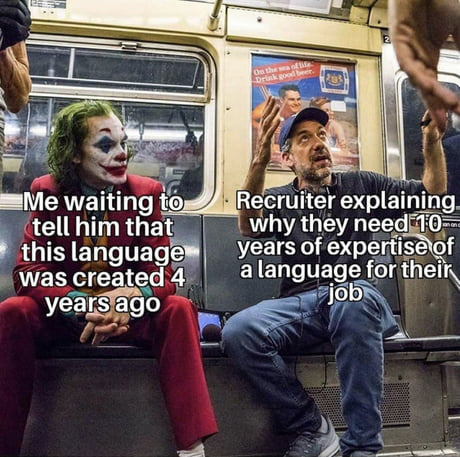
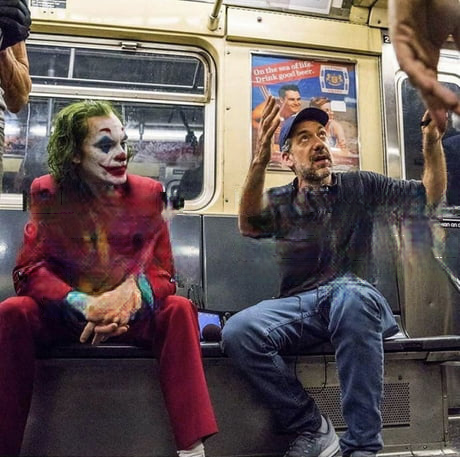


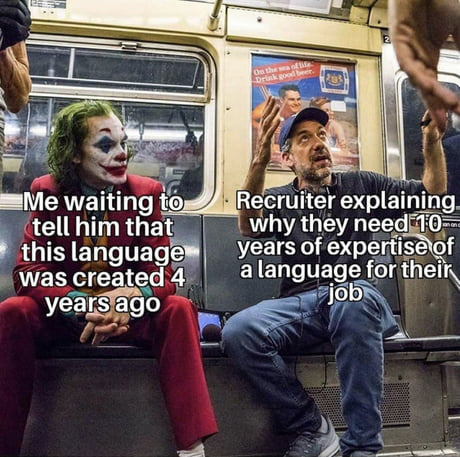
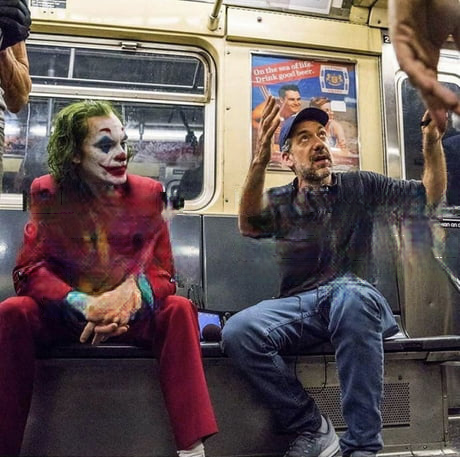

In [14]:
from google.colab import output
input_image_url = 'https://img-9gag-fun.9cache.com/photo/axMNd31_460s.jpg' #@param {type:"string"}


if input_image_url is not None and input_image_url !='':
    # source_image, output_image = pipeline(input_image_url, model_isr, model_translator, tokenizer_translator, font, debug=False)
    source_image, output_image = pipeline(input_image_url, debug=True)
    output.clear()
    ipyplot.plot_images([source_image, output_image], max_images=2, img_width=output_image.width)
else:
    print('Provide an image url and try again.')